In [7]:
#!pip install tensorflow

In [8]:
#!pip install scikit-learn

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [29]:
#Import svm model
from sklearn import svm
from sklearn import metrics

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
features = pd.read_pickle("feat_backpack.pickle")

In [10]:
features.head()

,main_bg_tokens,main_consistent_bg_token,main_fg_tokens,main_consistent_fg_token,second_bg_tokens,second_consistent_bg_token,second_fg_tokens,second_consistent_fg_token,layer_11_act,layer_10_act,layer_09_act,class,labels
0,"[{'max_image': 156, 'max_obj': 156, 'min_obj':...",92.0,"[{'max_image': 156, 'max_obj': 72, 'min_obj': ...",72.0,"[{'max_image': 156, 'max_obj': 156, 'min_obj':...",92.0,"[{'max_image': 156, 'max_obj': 178, 'min_obj':...",178.0,"[[3.9636064, -3.344161, 0.018599555, -0.680718...","[[2.3967972, -2.2439294, -1.6943444, -0.963295...","[[2.3873458, -1.3841065, -1.6437932, -0.918038...",backpack,0
1,"[{'max_image': 170, 'max_obj': 170, 'min_obj':...",170.0,"[{'max_image': 170, 'max_obj': 42, 'min_obj': ...",70.0,"[{'max_image': 170, 'max_obj': 170, 'min_obj':...",170.0,"[{'max_image': 170, 'max_obj': 60, 'min_obj': ...",60.0,"[[3.0557942, -4.3884687, -1.9317892, 0.5815902...","[[1.7552422, -3.0687892, -1.209787, 1.9393528,...","[[1.880189, -1.7407998, -0.83776057, 0.3473085...",backpack,0
2,"[{'max_image': 19, 'max_obj': 19, 'min_obj': 3...",148.0,"[{'max_image': 19, 'max_obj': 86, 'min_obj': 1...",86.0,"[{'max_image': 19, 'max_obj': 19, 'min_obj': 3...",148.0,None,NaN,"[[3.288642, -1.9042169, -5.040059, 0.023156375...","[[1.6052028, -1.816736, -2.782751, 0.22806424,...","[[1.2008154, -1.0786269, -1.777029, -0.4010378...",backpack,0
3,"[{'max_image': 173, 'max_obj': 173, 'min_obj':...",173.0,"[{'max_image': 173, 'max_obj': 19, 'min_obj': ...",120.0,"[{'max_image': 173, 'max_obj': 173, 'min_obj':...",173.0,"[{'max_image': 173, 'max_obj': 116, 'min_obj':...",145.0,"[[1.2662159, 2.6536717, -3.1891391, -0.4909477...","[[0.400926, -0.2360898, -0.8044621, 2.2384477,...","[[0.017914236, 1.346952, -0.32394043, 2.601256...",backpack,0
4,"[{'max_image': 10, 'max_obj': 10, 'min_obj': 5...",161.0,"[{'max_image': 10, 'max_obj': 105, 'min_obj': ...",119.0,"[{'max_image': 10, 'max_obj': 10, 'min_obj': 5...",161.0,None,NaN,"[[2.6675725, 0.20362961, -0.97527635, -1.24362...","[[-0.36094376, -1.458556, 0.8186226, -1.900530...","[[-0.158916, -0.69183946, 2.1854048, -2.364840...",backpack,0


In [11]:
# labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase']
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'bottle', 'cup', 'fork', 'knife', 'bowl', 'chair']
# (1, 27) ('person', 'backpack'): 3524
# (1, 28) ('person', 'umbrella'): 2089
# (1, 31) ('person', 'handbag'): 4890
# (1, 32) ('person', 'tie'): 1543
# (1, 33) ('person', 'suitcase'): 1048
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0,
 'umbrella': 1,
 'handbag': 2,
 'tie': 3,
 'suitcase': 4,
 'bottle': 5,
 'cup': 6,
 'fork': 7,
 'knife': 8,
 'bowl': 9,
 'chair': 10}

In [9]:
features["labels"] = features['class'].apply(lambda x: labels_to_idx[x])

In [17]:
len(features)

1001

In [30]:
features = features[(~features["second_fg_tokens"].isnull()) & (~features["main_fg_tokens"].isnull())]
features = features.reset_index(drop=True)
len(features)

608

In [31]:
token_strategy = 'max_obj'
layer = 0

In [37]:
token = features["main_fg_tokens"][0][layer][token_strategy]
x = features["layer_11_act"][0][token,:]
print(x.shape)
y = to_categorical(features["labels"].values.tolist())
print(y.shape)

(768,)
(608, 1)


In [34]:
x = np.zeros((len(features),768))
print(x.shape)
for idx, row in features.iterrows():
    token = row["main_fg_tokens"][layer][token_strategy]
    x[idx] = row["layer_09_act"][token,:]

(608, 768)


In [35]:
x.shape

(608, 768)

In [32]:
def base_model(model="NN"):
    if model == "NN":
        clf_model = Sequential()
        clf_model.add(Dense(256, input_dim=768, activation='relu'))
        clf_model.add(Dropout(0.5))
        clf_model.add(Dense(5))
        clf_model.add(Activation("softmax"))

    #     sgd = SGD(lr=0.001)
        adam = Adam()
        clf_model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    else:
        clf_model = svm.SVC(kernel='linear') # Linear Kernel
    return clf_model

In [38]:
files = ["feat_backpack.pickle", "feat_handbag.pickle", "feat_suitcase.pickle", "feat_tie.pickle", "feat_umbrella.pickle"]
token_strategies = ["consistent", 'max_image', 'max_obj', 'min_obj', 'random_obj']
# layer_strategy = 0
layers_map = {0: '09', 1: '10', 2: '11'}
layers = [0, 1, 2]
objects = ['main', 'second']
model = "svm"
          
histories = {}
test_scores = {}

histories = {}
test_scores = {}
for obj in objects:
    for strategy in token_strategies:
        for layer in layers:
            x = np.zeros((5000,768))
            y = np.zeros((5000,1))
            samples_i = 0

            for file in files:
                print(f"Processing file '{file}'")
                features = pd.read_pickle(file)
                features = features[:1000]
                features = features[(~features["second_fg_tokens"].isnull()) & 
                                    (~features["main_fg_tokens"].isnull()) & 
                                    (~features["second_consistent_fg_token"].isnull()) &
                                    (~features["main_consistent_fg_token"].isnull())]
                features["labels"] = features['class'].apply(lambda x: labels_to_idx[x])
                features = features.reset_index(drop=True)
                for idx, row in tqdm(features.iterrows()):
                    if strategy == 'consistent':
                        token = int(row[f"{obj}_consistent_fg_token"])
                    else:
                        token = int(row[f"{obj}_fg_tokens"][layer][strategy])

                    x[samples_i] = row[f"layer_{layers_map[layer]}_act"][token,:]
                    y[samples_i] = row["labels"]
                    samples_i += 1    

            x = x[:samples_i,:]
            y = y[:samples_i,:]
            if model=="NN":
                y = to_categorical(y)

            train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.10, 
                                                                                random_state=42, 
                                                                                shuffle=True)    
            clf_model = base_model(model)
            print(f"Training model: {layer}-{obj}-{strategy}")
            if model == "NN":                            
                hist = clf_model.fit(tf.stack(train_data), 
                                 tf.stack(train_labels), 
                                 validation_split=0.10,
                                 epochs=30, 
                                 batch_size=128, 
                                 verbose=0)
                histories[f"{layer}-{obj}-{strategy}"] = hist
                print("Evaluating model...")
                test_scores[f"{layer}-{obj}-{strategy}"] = clf_model.evaluate(tf.stack(test_data), tf.stack(test_labels), batch_size=len(test_data))
                print("Done...")
            else: 
                clf_model.fit(train_data, train_labels)
                y_pred = clf_model.predict(test_data)
                test_scores[f"{layer}-{obj}-{strategy}"] = metrics.accuracy_score(test_labels, y_pred)

Processing file 'feat_backpack.pickle'


1000it [00:00, 12463.35it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 20719.57it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 10608.04it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 10597.89it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12019.68it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-main-consistent
Processing file 'feat_backpack.pickle'


1000it [00:00, 12057.73it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 21698.87it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23071.99it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 11928.56it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12210.74it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-main-consistent
Processing file 'feat_backpack.pickle'


1000it [00:00, 12052.04it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12293.88it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23235.73it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12052.53it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 22398.29it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-main-consistent
Processing file 'feat_backpack.pickle'


1000it [00:00, 12319.48it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 22728.30it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 11999.19it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12259.53it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12236.43it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-main-max_image
Processing file 'feat_backpack.pickle'


1000it [00:00, 22795.63it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 21475.44it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 22131.08it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 22219.39it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 11865.41it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-main-max_image
Processing file 'feat_backpack.pickle'


1000it [00:00, 11916.99it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 11703.74it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 20565.56it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 22088.43it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12235.28it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-main-max_image
Processing file 'feat_backpack.pickle'


1000it [00:00, 11865.44it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12075.57it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23763.49it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12700.84it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 10789.10it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-main-max_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23579.67it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 11903.02it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12212.09it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12100.67it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12186.47it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-main-max_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 12169.50it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12113.90it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12047.47it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12106.26it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12118.66it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-main-max_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 12115.93it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12035.69it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12213.83it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 23367.57it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 18703.78it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-main-min_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 12092.91it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12152.22it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23697.44it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 14389.41it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23750.98it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-main-min_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 20187.44it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12217.07it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12100.76it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12052.01it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23837.37it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-main-min_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23536.40it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12003.86it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23421.40it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12120.90it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23709.36it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-main-random_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 22064.72it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12066.99it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12090.15it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12189.80it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12127.28it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-main-random_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23718.34it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 18822.55it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12197.78it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 15176.50it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12201.01it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-main-random_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 12159.38it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 23655.87it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23854.31it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12217.13it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23666.68it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-second-consistent
Processing file 'feat_backpack.pickle'


1000it [00:00, 23726.26it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12171.34it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23735.52it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12237.83it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23674.03it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-second-consistent
Processing file 'feat_backpack.pickle'


1000it [00:00, 23807.06it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 11958.85it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 13957.33it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 23591.23it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 24030.34it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-second-consistent
Processing file 'feat_backpack.pickle'


1000it [00:00, 12109.32it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12097.93it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23581.92it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 11885.25it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 20174.82it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-second-max_image
Processing file 'feat_backpack.pickle'


1000it [00:00, 23501.32it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 23682.85it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23589.88it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12145.18it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12002.28it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-second-max_image
Processing file 'feat_backpack.pickle'


1000it [00:00, 23708.29it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 11818.00it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12087.44it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 13784.80it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23603.82it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-second-max_image
Processing file 'feat_backpack.pickle'


1000it [00:00, 23588.02it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 11931.43it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12068.41it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 11875.92it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23673.49it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-second-max_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23605.81it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12193.52it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12168.58it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 11892.74it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23531.12it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-second-max_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23479.35it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 23594.26it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12208.47it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 23378.53it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 16443.22it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-second-max_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 12167.28it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 23464.51it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 19036.46it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12194.27it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 15050.02it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-second-min_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23628.55it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12158.64it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 11982.87it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12238.61it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12105.44it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-second-min_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23628.42it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12089.53it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12071.26it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 12227.93it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 23695.83it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-second-min_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 18485.66it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 12254.95it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12129.28it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 20588.50it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 20729.30it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 0-second-random_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 23406.11it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 23463.72it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 12203.85it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 23430.82it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 17973.53it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 1-second-random_obj
Processing file 'feat_backpack.pickle'


1000it [00:00, 12050.10it/s]


Processing file 'feat_handbag.pickle'


1000it [00:00, 18838.27it/s]


Processing file 'feat_suitcase.pickle'


1000it [00:00, 23486.58it/s]


Processing file 'feat_tie.pickle'


999it [00:00, 14255.52it/s]


Processing file 'feat_umbrella.pickle'


1000it [00:00, 12036.79it/s]
/home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model: 2-second-random_obj


In [39]:
len(histories.keys())

0

In [42]:
len(test_scores.keys())

30

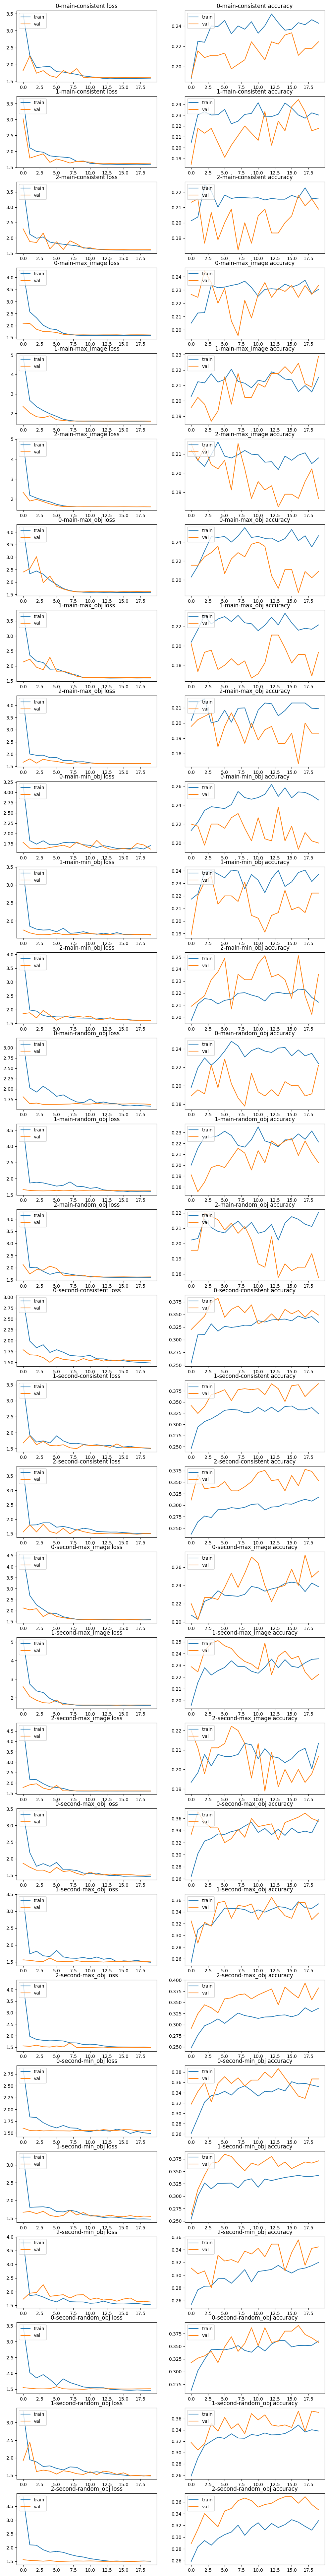

In [25]:
fig, axs = plt.subplots(nrows=30, ncols=2, figsize=(12, 100))
for idx, (layer_name, hist) in enumerate(histories.items()):
    axs[idx, 0].plot(hist.history['loss'])
    axs[idx, 0].plot(hist.history['val_loss'])
    axs[idx, 0].set_title(f'{layer_name} loss')
#     axs[idx, 0].ylabel('loss')
#     axs[idx, 0].xlabel('epoch')
    axs[idx, 0].legend(['train', 'val'], loc='upper left')

    axs[idx, 1].plot(hist.history['accuracy'])
    axs[idx, 1].plot(hist.history['val_accuracy'])
    axs[idx, 1].set_title(f'{layer_name} accuracy')
#     axs[idx, 1].ylabel('accuracy')
#     axs[idx, 1].xlabel('epoch')
    axs[idx, 1].legend(['train', 'val'], loc='upper left')

plt.show()

### Classification task summary:
* Number of instances per tuple, before cleaning. **Total 5 classes**.
    * (1, 27) ('person', 'backpack'): 3524
    * (1, 28) ('person', 'umbrella'): 2089
    * (1, 31) ('person', 'handbag'): 4890
    * (1, 32) ('person', 'tie'): 1543
    * (1, 33) ('person', 'suitcase'): 1048
* I had to limit the number of instances processed to 1000 because the extracted Tensor (hiddden states from 3 layers) became too big (5GB per tuple)
* from 5000 images, there were some issues with token selection and in the end **I was able to extract 2969 hidden states.**
    * these hidden states are from layers 10, 11 e 12 (3 last layers)
    * 10% split to test, 10% for validation
* Then, 30 NN were trained with the follow configurations:
    * 5 token_strategies = `["consistent", 'max_image', 'max_obj', 'min_obj', 'random_obj']`
        * `consistent`: consistent token which gets maximum activation across several layers within the foreground mask. One token per image.
        * `'max_obj', 'min_obj', 'random_obj'`: One token max/min/random **per layer** 10/11/12 within the foreground mask. 3 tokens per image, one for each one of the last 3 layers.
        * `'max_image'`: Token that gets maximum attention in the *whole image* .
    * 3 different layers (10,11,12): The hidden state to be used as input for the decoding task. 
    * 2 different objects: MAIN, SECOND.
        * a model is trained for each one of the 15 combinations of token * layer for the `MAIN` object and `SECOND` object.
        
**TOTAL OF 30 models**

In [23]:
scores_pd = {'object': [], 'token_strategy': [], 'hidden_state_layer': [], 'loss': [], 'test_score': []}
for model_name, score in test_scores.items():
    scores_pd['hidden_state_layer'].append(int(model_name[0])+10)
    scores_pd['object'].append(model_name[2:model_name.rfind('-')])
    scores_pd['token_strategy'].append(model_name[model_name.rfind('-')+1:])
    scores_pd['loss'].append(score[0])
    scores_pd['test_score'].append(score[1])

scores_pd = pd.DataFrame(scores_pd)
scores_pd

,object,token_strategy,hidden_state_layer,loss,test_score
0,main,consistent,10,1.624377,0.208
1,main,consistent,11,1.614972,0.194
2,main,consistent,12,1.615392,0.194
3,main,max_image,10,1.622713,0.184
4,main,max_image,11,1.603776,0.218
5,main,max_image,12,1.609430,0.206
6,main,max_obj,10,1.611561,0.206
7,main,max_obj,11,1.618591,0.186
8,main,max_obj,12,1.614495,0.172
9,main,min_obj,10,1.890197,0.190


In [26]:
scores_pd.to_csv("5_class_object_decoding_closest.csv", index=False)

In [45]:
scores_pd = scores_pd.rename(columns={"test_score": "NN_test_score"})

In [47]:
scores_pd["SVM_test_score"] = list(test_scores.values())
    

In [48]:
scores_pd

,object,token_strategy,hidden_state_layer,loss,NN_test_score,SVM_test_score
0,main,consistent,10,1.624377,0.208,0.184
1,main,consistent,11,1.614972,0.194,0.180
2,main,consistent,12,1.615392,0.194,0.182
3,main,max_image,10,1.622713,0.184,0.226
4,main,max_image,11,1.603776,0.218,0.198
5,main,max_image,12,1.609430,0.206,0.222
6,main,max_obj,10,1.611561,0.206,0.204
7,main,max_obj,11,1.618591,0.186,0.200
8,main,max_obj,12,1.614495,0.172,0.178
9,main,min_obj,10,1.890197,0.190,0.202


In [49]:
scores_pd.to_csv("5_class_object_decoding_closest_svm.csv", index=False)